In [23]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We use: {device}")

We use: cuda


### I. Datasets and Dataloaders

In [3]:
path_chest_imagenome_customized = "/u/home/tanida/datasets/chest-imagenome-dataset-customized-full"

# reduce memory usage by only using necessary columns and selecting appropriate datatypes
usecols = ["mimic_image_file_path", "bbox_name", "x1", "y1", "x2", "y2", "is_abnormal"]
dtype = {"x1": "int16", "x2": "int16", "y1": "int16", "y2": "int16", "bbox_name": "category"} 

datasets_as_dfs = {dataset: os.path.join(path_chest_imagenome_customized, dataset) + ".csv" for dataset in ["train", "valid", "test"]}
datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, dtype=dtype) for dataset, csv_file_path in datasets_as_dfs.items()}

In [4]:
def print_num_samples_per_class(dataset, df):
    print(f"{dataset}:")
    for bbox_name, count in df["bbox_name"].value_counts().iteritems():
        print(f"\t{bbox_name}: {count}")
    print()

In [30]:
# get number of samples per class for each dataset

# bboxes of anatomical regions are almost distributed equally in all datasets,
# only a slight imbalance because not every image has bboxes of all 36 anatomical regions
for dataset, df in datasets_as_dfs.items():
    print_num_samples_per_class(dataset, df)

train:
	cardiac silhouette: 166490
	left lung: 166460
	mediastinum: 166456
	right lung: 166431
	spine: 166281
	trachea: 166280
	abdomen: 166276
	right upper abdomen: 166276
	left cardiac silhouette: 166272
	left upper abdomen: 166263
	upper mediastinum: 166260
	right upper lung zone: 166259
	right atrium: 166253
	left hemidiaphragm: 166237
	left upper lung zone: 166226
	right cardiac silhouette: 166214
	right hemidiaphragm: 166172
	right costophrenic angle: 166137
	cavoatrial junction: 166096
	right cardiophrenic angle: 166001
	left costophrenic angle: 165875
	svc: 165755
	left cardiophrenic angle: 165753
	descending aorta: 165705
	right clavicle: 165587
	left clavicle: 165442
	carina: 165188
	aortic arch: 164718
	right lower lung zone: 162983
	right mid lung zone: 162889
	right hilar structures: 162883
	right apical zone: 162836
	left lower lung zone: 162582
	left apical zone: 162386
	left hilar structures: 162170
	left mid lung zone: 162146

valid:
	cardiac silhouette: 23949
	right l

In [5]:
# get number of samples for each dataset
total_num_samples = sum(len(df) for df in datasets_as_dfs.values())

for dataset, df in datasets_as_dfs.items():
    print(f"{dataset}: {len(df):,} samples ({(len(df) / total_num_samples) * 100:.2f}%)")

train: 5,950,238 samples (70.00%)
valid: 855,467 samples (10.06%)
test: 1,694,389 samples (19.93%)


In [6]:
# if we don't want to train on the full train set (with 5,950,238 samples), we can specify the constant below to limit the train set

PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.3
total_num_samples_train = len(datasets_as_dfs["train"])

new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)

datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]

print(f"train (new): {len(datasets_as_dfs['train']):,} samples")

train: 1,785,071 samples


In [8]:
datasets_as_dfs["train"].head()

,mimic_image_file_path,bbox_name,x1,y1,x2,y2,is_abnormal
0,/u/home/tanida/datasets/mimic-cxr-jpg/files/p1...,right lung,225,144,803,1381,True
1,/u/home/tanida/datasets/mimic-cxr-jpg/files/p1...,right upper lung zone,406,171,929,550,False
2,/u/home/tanida/datasets/mimic-cxr-jpg/files/p1...,right mid lung zone,343,550,803,848,False
3,/u/home/tanida/datasets/mimic-cxr-jpg/files/p1...,right lower lung zone,225,848,848,1381,False
4,/u/home/tanida/datasets/mimic-cxr-jpg/files/p1...,right hilar structures,722,487,803,902,True


In [37]:
ANATOMICAL_REGIONS = {
    "right lung": 0,
    "right upper lung zone": 1,
    "right mid lung zone": 2,
    "right lower lung zone": 3,
    "right hilar structures": 4,
    "right apical zone": 5,
    "right costophrenic angle": 6,
    "right cardiophrenic angle": 7,
    "right hemidiaphragm": 8,
    "left lung": 9,
    "left upper lung zone": 10,
    "left mid lung zone": 11,
    "left lower lung zone": 12,
    "left hilar structures": 13,
    "left apical zone": 14,
    "left costophrenic angle": 15,
    "left hemidiaphragm": 16,
    "trachea": 17,
    "spine": 18,
    "right clavicle": 19,
    "left clavicle": 20,
    "aortic arch": 21,
    "mediastinum": 22,
    "upper mediastinum": 23,
    "svc": 24,
    "cardiac silhouette": 25,
    "left cardiac silhouette": 26,
    "right cardiac silhouette": 27,
    "cavoatrial junction": 28,
    "right atrium": 29,
    "descending aorta": 30,
    "carina": 31,
    "left upper abdomen": 32,
    "right upper abdomen": 33,
    "abdomen": 34,
    "left cardiophrenic angle": 35,
}

In [48]:
labels = datasets_as_dfs["train"].iloc[2, [1, 6]].tolist()
region_class_index = ANATOMICAL_REGIONS[labels[0]]
is_abnormal_int = int(labels[1])

labels = torch.Tensor([region_class_index, is_abnormal_int])
labels

tensor([2., 0.])

In [49]:
datasets_as_dfs["train"].iloc[2, 1]

'right mid lung zone'

In [15]:
# specify path to folder where model weights should be saved
model_save_path = "/u/home/tanida/weights/encoder"

In [10]:
from PIL import Image

(818, 723)


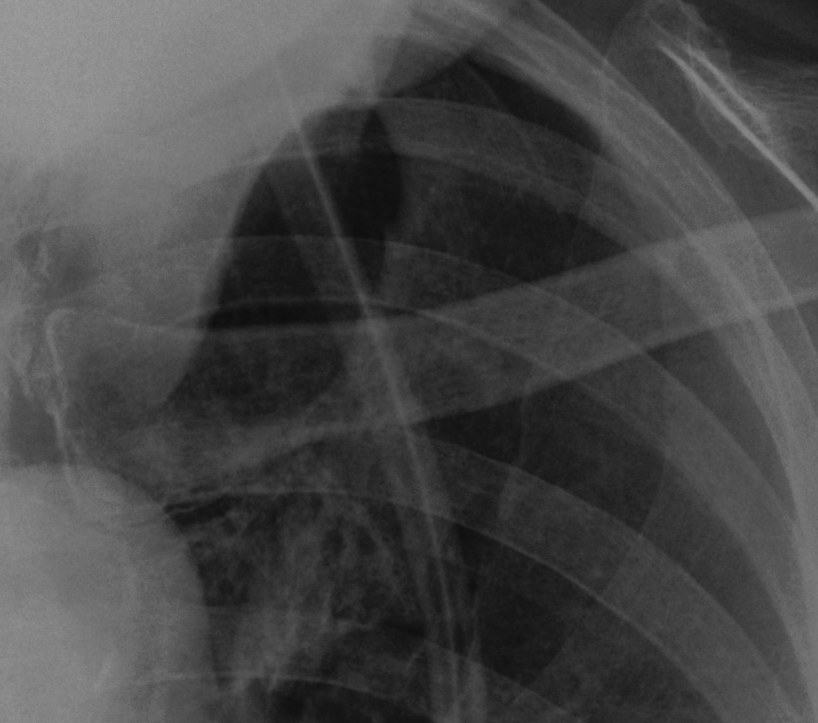

In [14]:
image_file_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg"
img = Image.open(image_file_path)
box = [1364, 409, 2182, 1132]
cropped_img = img.crop(box=box)
print(cropped_img.size)
display(cropped_img)